This notebook contains the production version of the BERT neural network for Sereniiti. It is not the production code for inference but the code that is used to train, test and improve the model.

# Training

## Parameters

In [7]:
# Set the number of epochs for the training
epochs = 1

# Name of the BERT model to use
model_name = 'distilbert-base-uncased'

# Max length of the sentences
max_length = 120

## Installs and imports

In [8]:
!pip install -q -U bert-tensorflow
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official
!pip install -q -U transformers
!pip install -q -U tensorflowjs

In [9]:
# Base libraries
import datetime, os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Huggingface transformers
from transformers import DistilBertConfig,  DistilBertTokenizer, TFDistilBertModel

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [10]:
# Check if the GPU can be found or use the CPU
DEVICE = '/device:CPU:0' if tf.test.is_gpu_available() else 'cpu'

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


## Open the dataset

In [11]:
# We use the URL method as it is the most resillient when working as a team

# URL of the dataset:
URL = 'https://drive.google.com/file/d/1aiAwidHz9Bqh_n_9oOv1LLx1rLghhhab/view?usp=sharing'

# We transform it into a downloadable URL
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]

# Prepare a list to drop columns with no use
cols = list(pd.read_csv(path, nrows =1))
drop_cols = ["id","Unnamed: 0","fr","tips","tips_groups","steps"]
drop_prefix = "tip_"
usecols = [i for i in cols if (i not in drop_cols) and not (i.startswith(drop_prefix))]

# Read the csv and drop na values
df = pd.read_csv(path, usecols=usecols).dropna()

# Correct the type issue on fivefold
df.fivefold = df.fivefold.astype(int)

# print the dataframe
df.describe()

,rating,fivefold,step_facts,step_emotions,step_needs,step_proposals,group_empathy,group_negative,group_feeling,group_fault,group_unsolicited,group_need,group_realistic,group_precise,group_unprecise,group_unrealistic,group_provocation,group_positivebias,group_judgemental,group_demanding,group_fact,group_positive
count,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000
mean,2.559149,2.983872,0.819849,0.212583,0.033141,0.191050,0.158175,0.027381,0.188658,0.207355,0.086752,0.029863,0.073195,0.023039,0.054763,0.002836,0.093221,0.048294,0.361187,0.006292,0.191405,0.048383
std,1.694178,1.407400,0.384330,0.409153,0.179013,0.393146,0.364921,0.163200,0.391254,0.405430,0.281484,0.170216,0.260467,0.150035,0.227527,0.053177,0.290755,0.214397,0.480366,0.079073,0.393424,0.214583
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Extract the variables

In [12]:
def train_test_split(df,columns=None,test_fold=5):
    """
    This function take a dataframe (slice) and cut it between the train and test set.
    """
    col = columns or df.drop(columns = "fivefold").columns
    df_full = df.drop(columns = "fivefold").loc[:,col]
    df_train = df.loc[df["fivefold"] != test_fold,:].drop(columns = "fivefold").loc[:,col]
    df_test  = df.loc[df["fivefold"] == test_fold,:].drop(columns = "fivefold").loc[:,col]
    return df_full, df_train, df_test

def cols_prefixed(df,prefix):
    return [col for col in df if col.startswith(prefix)]

In [13]:
# X
text, text_train, text_test = train_test_split(df,columns="en")

# Y1
step_cols = cols_prefixed(df,"step_")
step, step_train, step_test = train_test_split(df,columns=step_cols)

# Y2
group_cols = cols_prefixed(df,"group_")
group, group_train, group_test = train_test_split(df,columns=group_cols)

# Y3
df["scaled_rating"] = df["rating"]/5
rating, rating_train, rating_test = train_test_split(df,columns="scaled_rating")

In [14]:
# Steps and groups are already one hot encoded. We just need to extract the numpy arrays

# Step
Y1 = tf.convert_to_tensor(step_train.values, dtype=tf.float32)
# Group
Y2 = tf.convert_to_tensor(group_train.values, dtype=tf.float32)
# Rating
Y3 = tf.convert_to_tensor(rating_train.values, dtype=tf.float32)

print("Shape of Y1:", np.shape(Y1))
print("Shape of Y2:", np.shape(Y2))
print("Shape of Y3:", np.shape(Y3))

Shape of Y1: (9108, 4)
Shape of Y2: (9108, 16)
Shape of Y3: (9108,)


## Load the BERT model

In [15]:
# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

config

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.3",
  "vocab_size": 30522
}

In [16]:
# Load BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

tokenizer

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [17]:
# Load the Transformers BERT model
encoder = TFDistilBertModel.from_pretrained(model_name, config = config)

encoder

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Tokenize the text

In [18]:
# Tokenize the input (takes some time)
X = tokenizer(
    text=text_train.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

X

{'input_ids': <tf.Tensor: shape=(9108, 120), dtype=int32, numpy=
array([[  101,  3438,  1010, ...,     0,     0,     0],
       [  101,  1037,  2502, ...,     0,     0,     0],
       [  101,  1037, 18178, ...,     0,     0,     0],
       ...,
       [  101,  2052,  2017, ...,     0,     0,     0],
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  2169,  2051, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(9108, 120), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(9108, 120), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

## Create the model

In [19]:
# Create model function
def create_model():

    # Build your model input
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
    
    inputs = {
        'input_ids': input_ids, 
        'attention_mask': attention_mask
        }
    
    # BERT, loading the model
    bert_model = encoder(input_ids=input_ids, attention_mask=attention_mask)

    # Make sure BERT weights stay the same during training
    bert_model.trainable = False

    # Get the last hiddent state as an imput for the next layer
    bert_output = bert_model[0]
    print(bert_output)

    # DistilBERT output the sentence embedding on the [CLS] token at index 0 of each sentence
    embedding = bert_output[:, 0, :]

    # Additional layers for non-linear classification
    hidden = Dense(512, name="hidden")(embedding)
    output = Dense(125, name="output")(hidden)

    # Then build the model output
    Y1_output = Dense(units=Y1.shape[1], name='Y1')(output)
    Y2_output = Dense(units=Y2.shape[1], name='Y2')(output)
    Y3_output = Dense(1, name='Y3')(output)
    outputs = {'Y1': Y1_output, 'Y2': Y2_output, 'Y3': Y3_output}

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='BERT_Sereniiti')

    # Set an optimizer
    optimizer = Adam(
        learning_rate=5e-05,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)

    # Set loss functions
    loss = {
        'Y1': CategoricalCrossentropy(from_logits = True), 
        'Y2': CategoricalCrossentropy(from_logits = True),
        'Y3': tf.keras.losses.MeanSquaredError()
        }

    # Set metrics    
    metric = {
        'Y1': CategoricalAccuracy('accuracy'),
        'Y2': CategoricalAccuracy('accuracy'),
        'Y3': tf.keras.metrics.MeanSquaredError('mse')
        }

    # Compile the model
    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric)

    return model


# Create with GPU
with tf.device(DEVICE):
    model = create_model()
    
# Take a look at the model
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 120, 768), dtype=tf.float32, name=None), name='tf_distil_bert_model/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0', description="created by layer 'tf_distil_bert_model'")
Model: "BERT_Sereniiti"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 120)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                           

## Train the model

In [20]:
def print_dimensions(dic):
    """Print the dimensions of the tensors in a dict"""
    for i in dic.items():
        print(i[0], i[1].shape)

In [21]:
# Training input
x = {'input_ids': X['input_ids'], 'attention_mask': X['attention_mask']}

print_dimensions(x)

input_ids (9108, 120)
attention_mask (9108, 120)


In [22]:
# Training output
y = {'Y1': Y1, 'Y2': Y2, 'Y3': Y3}

print_dimensions(y)

Y1 (9108, 4)
Y2 (9108, 16)
Y3 (9108,)


In [23]:
# Training phase
with tf.device(DEVICE):
    history = model.fit(
        x=x,
        y=y,
        validation_split=0.2,
        batch_size=64,
        epochs=epochs,
        )

114/114 [==============================] - 4816s 42s/step - loss: 4.5183 - Y1_loss: 1.1333 - Y2_loss: 3.2400 - Y3_loss: 0.1450 - Y1_accuracy: 0.8117 - Y2_accuracy: 0.4919 - Y3_mse: 0.1450 - val_loss: 4.3181 - val_Y1_loss: 0.6803 - val_Y2_loss: 3.5563 - val_Y3_loss: 0.0814 - val_Y1_accuracy: 0.9479 - val_Y2_accuracy: 0.3825 - val_Y3_mse: 0.0814


## Plot

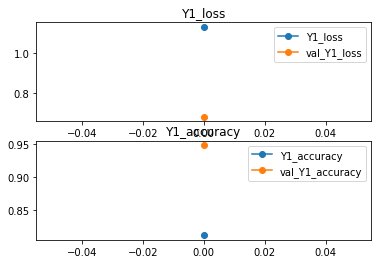

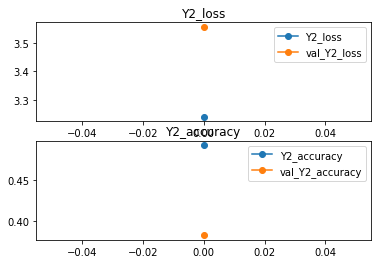

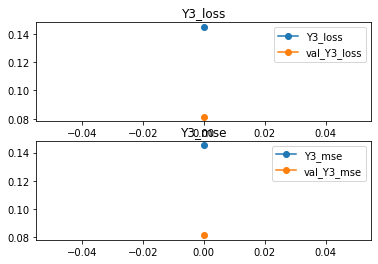

In [24]:
def plot_history(loss,metric):
    """
    Plot the loss and metric with the provided names, contained in the history
    """

    # plot loss during training
    plt.subplot(211)
    plt.title(loss)
    plt.plot(history.history[loss], label=loss, marker='o')
    plt.plot(history.history[f'val_{loss}'], label=f'val_{loss}', marker='o')
    plt.legend()

    # plot accuracy during training
    plt.subplot(212)
    plt.title(metric)
    plt.plot(history.history[metric], label=metric, marker='o')
    plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}', marker='o')
    plt.legend()
    plt.show()


plot_history('Y1_loss','Y1_accuracy')
plot_history('Y2_loss','Y2_accuracy')
plot_history('Y3_loss','Y3_mse')

# Testing

## Prepare the test data

In [25]:
# steps and groups are already one hot encoded
# We just need to extract the numpy arrays
Y1_test = step_test.values
Y2_test = group_test.values
Y3_test = rating_test.values

x_test={'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}

print_dimensions(x_test)

NameError: ignored

In [ ]:
# Output
y_test={'Y1': Y1_test, 'Y2': Y2_test, 'Y3': Y3_test}

print_dimensions(y_test)

## Tokenize

In [ ]:
# Test sentences
X_test = tokenizer(
    text=text_test.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

## Evalutate

In [ ]:
# Run evaluation
with tf.device(DEVICE):
    model_eval = model.evaluate(
        x=x_test,
        y=y_test
    )

In [ ]:
print("Y1_accuracy (step):",round(model_eval[-3],2))
print("Y2_accuracy (group):",round(model_eval[-2],2))
print("Y3_mse (rating):",round(model_eval[-1],3))

# Save the model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/model')

# Test the saved model for inference

In [ ]:
# Load the model from disk
new_model = tf.keras.models.load_model('saved_model/model')

# Check its architecture
new_model.summary()

In [ ]:
# Evaluate the restored model
with tf.device(DEVICE):
    model_eval = new_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=2
    )

In [ ]:
# Test it on a sentence

sentence = "I love chocolate"

embedded_sentence = tokenizer(
    text=sentence.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

new_model.predict(embedded_sentence)